# Introduction

In this notebook, we want to analyze eviction data in nyc using DBSCAN and kmeans clustering algos. Following the previous notebook, we use the cleaned data to test on both techniques and compare their results. Quick viz and metrics are provided to assess the effectiveness of each approach.

In [27]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# !pip install geopandas contextily
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [2]:
import hdbscan

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from shapely.geometry import Point

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio
import contextily as ctx

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

# **Step 1: Get the Eviction data**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# data source:
file_path = '/content/drive/My Drive/X999/evictions_pre_post_covid.csv'

# evictions_covid.csv
# evictions_pre_post_covid.csv

In [6]:
evictions_cleaned_raw = pd.read_csv(file_path)

In [7]:
evictions_cleaned = evictions_cleaned_raw.copy()

In [8]:
evictions_cleaned.head(2)

,primary_key,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,...,community_board,council_district,census_tract,bin,bbl,nta,year,month_year,geometry,average_year_eviction_count
0,*308072/22_5865,*308072/22,5865,356 MILLER AVE,1 AND BASEMENT,2024-12-04,BROOKLYN,11207,Not an Ejectment,Possession,...,5.0,37.0,1152.0,3083989,3037420029,East New York,2024,2024-12,POINT (-73.891105 40.672121),0.8
1,*313639/23_5202,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,...,7.0,38.0,118.0,3143881,3057940012,Sunset Park East,2024,2024-03,POINT (-74.011883 40.635941),0.6


In [9]:
evictions_cleaned.columns, \
evictions_cleaned.shape

(Index(['primary_key', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'eviction_postcode', 'ejectment',
        'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
        'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
        'month_year', 'geometry', 'average_year_eviction_count'],
       dtype='object'),
 (76718, 22))

## Part 3.2 DBSCAN

- Density-based spatial clustering of applications with noise (DBSCAN) is a clustering algorithm used in machine learning to partition data into clusters based on their distance to other points. Its effective at identifying and removing noise in a data set, making it useful for data cleaning and outlier detection.

#####  https://builtin.com/articles/dbscan#:~:text=What%20Is%20DBSCAN%3F,their%20distance%20to%20other%20points.
#####  https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data

### Part 3.2.1 Prepare the data for DBSCAN test

- Why didn't log the average eviction data points first?

- We have tried log it first before send the data for further processing, but it only yields one cluster. Therefore logging it just compress the data too much and therefore it is not a good way to process the data in this case

- We chose DBSCAN here, because it does not presumbly ask for the number of clusters, whereas K means does. K means also assume the clusters are in circular form, which may not be the case with geo data

# **Step 2: Prepare the data for HDBSCAN**

## **Step 2.1: HDBSCAN**

In [10]:
evictions_cleaned.columns, evictions_cleaned.shape

(Index(['primary_key', 'court_index_number', 'docket_number',
        'eviction_address', 'eviction_apartment_number', 'executed_date',
        'borough', 'eviction_postcode', 'ejectment',
        'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
        'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
        'month_year', 'geometry', 'average_year_eviction_count'],
       dtype='object'),
 (76718, 22))

In [66]:
evictions_cleaned.columns

Index(['primary_key', 'court_index_number', 'docket_number',
       'eviction_address', 'eviction_apartment_number', 'executed_date',
       'borough', 'eviction_postcode', 'ejectment',
       'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
       'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'year',
       'month_year', 'geometry', 'average_year_eviction_count', 'cluster',
       'cluster_kmeans'],
      dtype='object')

In [154]:
# use eviction_count for clustering
eviction_counts = evictions_cleaned[['average_year_eviction_count','latitude', 'longitude']]

In [155]:
# normalize the eviction_counts
scaler = StandardScaler()
eviction_counts_scaled = scaler.fit_transform(eviction_counts)

In [14]:
# apply DBSCAN
# dbscan = DBSCAN(eps=2, min_samples=3)
# dbscan = DBSCAN(eps=2, min_samples=3)
# this will crashhow to

In [156]:
# evictions_cleaned['cluster'] = dbscan.fit_predict(eviction_counts_scaled) # this will crash
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, metric='euclidean')
# can't predefined clusters
# won't crash

In [157]:
evictions_cleaned['cluster'] = clusterer.fit_predict(eviction_counts_scaled)

In [158]:
len(evictions_cleaned['cluster'].unique())
# dbscan is 5 with four of the categories with no variance

156

In [159]:
# analyze the number of clusters formed and noise points
n_clusters = len(set(evictions_cleaned['cluster'])) - (1 if -1 in evictions_cleaned['cluster'] else 0)
n_noise = list(evictions_cleaned['cluster']).count(-1)

In [160]:
print("results: number of clusters: ", n_clusters, "number of noise points: ", n_noise, evictions_cleaned.shape[0])
# makes sense, many should be noise points, as they do not belong to any typical clusters.

results: number of clusters:  156 number of noise points:  38407 76718


In [161]:
# -1 would be noise label
print(evictions_cleaned['cluster'].unique())

[ -1 103  95 150 129  30  39  25  46  47  52 104 149  53  56 120 131  82
  62  43 116  49 130  34  23 122  35 147  29 140  42  31   6  63  55  70
  60 115  38 141 113  61  97 145  54  44 110  13  64 134  32 125  18 108
  76 119  77 124   1  69  98   2  33  10  93  45  99  79 137  26 139 121
  24 106  68  37 107   5  87  27  84 100  66 152  91 146  58 142 105 154
  88 138  12  36  73 128  75  48 127 112  72  89  71  80 153 144  92  65
  90  40  22 135 114  59  57  78 151 101   4 143 118 123 136 148  15 132
 102 109 133  41  86  85  67   0 111 126   7  96  94   8   9  81  21  50
  16  17 117  11   3  74  20  51  14  83  19  28]


In [162]:
evictions_cleaned['cluster'].value_counts()

,count
cluster,
-1,38407
154,3114
56,2263
149,2088
122,1850
...,...
123,52
80,51
51,51


In [164]:
# # visualize the clusters
# plt.scatter(evictions_cleaned['average_year_eviction_count'], [0]*len(evictions_cleaned), c=evictions_cleaned['cluster'], cmap='viridis')
# plt.xlabel('average_year_eviction_count')
# plt.title('eviction clustering with DBSCAN')
# plt.show()
# # will reorder later

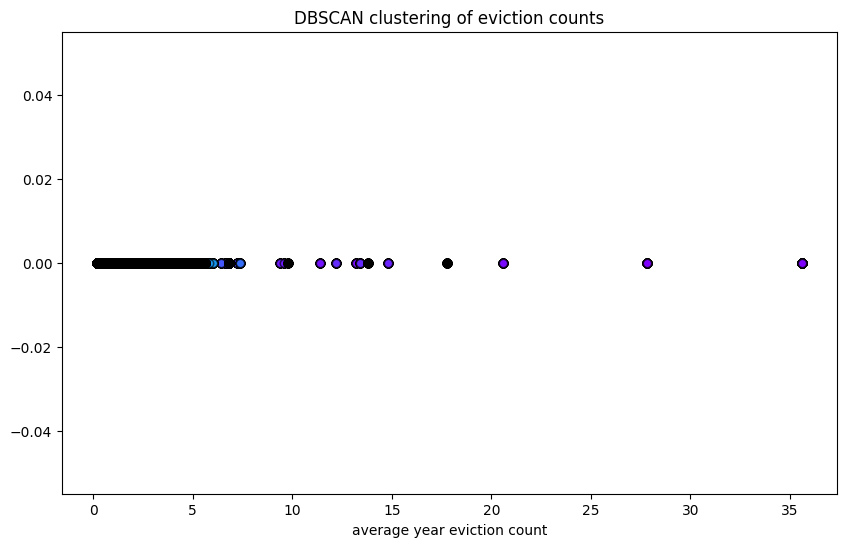

In [79]:
# better visuals
plt.figure(figsize=(10, 6))

for cluster_id in set(evictions_cleaned['cluster']):
    # default: noise points
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        color = plt.cm.rainbow(cluster_id / n_clusters)
        label = f'Cluster {cluster_id}'

    plt.scatter(evictions_cleaned[evictions_cleaned['cluster'] == cluster_id]['average_year_eviction_count'],
                [0] * len(evictions_cleaned[evictions_cleaned['cluster'] == cluster_id]),
                color=color, label=label, alpha=0.6, edgecolor='k')

plt.title('DBSCAN clustering of eviction counts')
plt.xlabel('average year eviction count')
# plt.legend()
plt.show()


## **Step 2.2: quick check with k-means:**

In [165]:
# self defined 45 here to match with HDBSCAN's answer
kmeans = KMeans(n_clusters=156, random_state=42)
evictions_cleaned['cluster_kmeans'] = kmeans.fit_predict(eviction_counts_scaled)

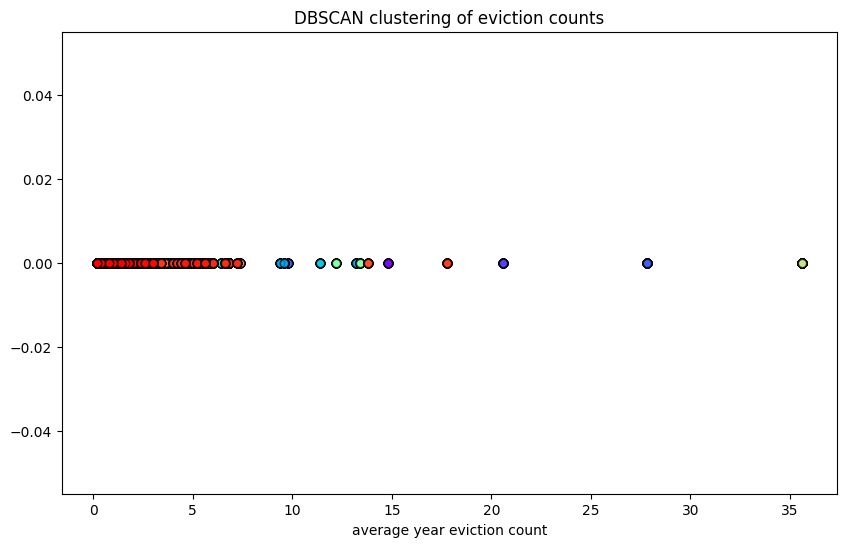

In [83]:
# better visuals
plt.figure(figsize=(10, 6))
for cluster_id in set(evictions_cleaned['cluster_kmeans']):
    if cluster_id == -1:
        color = 'black'
        # we have some
        label = 'Noise'
    else:
        color = plt.cm.rainbow(cluster_id / n_clusters)
        label = f'Cluster {cluster_id}'

    plt.scatter(evictions_cleaned[evictions_cleaned['cluster_kmeans'] == cluster_id]['average_year_eviction_count'],
                [0] * len(evictions_cleaned[evictions_cleaned['cluster_kmeans'] == cluster_id]),
                color=color, label=label, alpha=0.6, edgecolor='k')

plt.title('DBSCAN clustering of eviction counts')
plt.xlabel('average year eviction count')
# plt.legend()
plt.show()


In [166]:
# # visualize the clusters
# plt.scatter(evictions_cleaned['average_year_eviction_count'], [0]*len(evictions_cleaned), c=evictions_cleaned['cluster_kmeans'], cmap='viridis')
# plt.xlabel('average_year_eviction_count')
# plt.title('eviction clustering with kmeans')
# plt.show()

In [84]:
# dbscan_labels = evictions_cleaned['cluster'].dropna().unique()
# kmeans_labels = evictions_cleaned['cluster_kmeans'].dropna().unique()

# **Step 3: Re-order the cluster labels for each clustering alorithm. Check how many clusters defined by either HDBSCAN and KMEANS were overlapped.**

## **Step 3.1 Before re-order check**

In [167]:
# before re-ordering
overlappeded_clusters = evictions_cleaned.query("cluster == cluster_kmeans")
overlappeded_clusters.shape, evictions_cleaned.shape
# so only 650 out of 76718 records were overlapped? need to make sure their clustering definition is the same
# to be based on median eviction rates of each cluster

((74, 24), (76718, 24))

In [168]:
same_clusters_count = (evictions_cleaned['cluster'] == evictions_cleaned['cluster_kmeans']).sum()
same_clusters_count
# so correct

np.int64(74)

In [169]:
overlap_counts = (
    evictions_cleaned.dropna()
    .groupby(['cluster', 'cluster_kmeans'])
    .size()
    .reset_index(name='record_count')
)
overlap_records = overlap_counts['cluster'] == overlap_counts['cluster_kmeans']
overlap_counts = overlap_counts[overlap_records]
overlap_counts
# this is random and meaningless

,cluster,cluster_kmeans,record_count
395,133,133,74


In [170]:
overlap_counts.record_count.sum()

np.int64(74)

## **Step 3.2 Reorder**

In [171]:
cluster_means_pre_post = evictions_cleaned.groupby('cluster')['average_year_eviction_count'].mean()
cluster_counts_pre_post = evictions_cleaned.groupby('cluster')['average_year_eviction_count'].count()
cluster_medians_pre_post = evictions_cleaned.groupby('cluster')['average_year_eviction_count'].median()
cluster_stds_pre_post = evictions_cleaned.groupby('cluster')['average_year_eviction_count'].std()
cluster_maxs_pre_post = evictions_cleaned.groupby('cluster')['average_year_eviction_count'].max()
cluster_mins_pre_post = evictions_cleaned.groupby('cluster')['average_year_eviction_count'].min()

cluster_means_pre_post_k = evictions_cleaned.groupby('cluster_kmeans')['average_year_eviction_count'].mean()
cluster_counts_pre_post_k = evictions_cleaned.groupby('cluster_kmeans')['average_year_eviction_count'].count()
cluster_medians_pre_post_k = evictions_cleaned.groupby('cluster_kmeans')['average_year_eviction_count'].median()
cluster_stds_pre_post_k = evictions_cleaned.groupby('cluster_kmeans')['average_year_eviction_count'].std()
cluster_maxs_pre_post_k = evictions_cleaned.groupby('cluster_kmeans')['average_year_eviction_count'].max()
cluster_mins_pre_post_k = evictions_cleaned.groupby('cluster_kmeans')['average_year_eviction_count'].min()

In [172]:
mean_series = pd.Series(cluster_means_pre_post, name = 'mean')
median_series = pd.Series(cluster_medians_pre_post, name = 'median')
std_series = pd.Series(cluster_stds_pre_post, name = 'std')
max_series = pd.Series(cluster_maxs_pre_post, name = 'max')
min_series = pd.Series(cluster_mins_pre_post, name = 'min')
count_series = pd.Series(cluster_counts_pre_post, name = 'count')

mean_series_k = pd.Series(cluster_means_pre_post_k, name = 'mean')
median_series_k = pd.Series(cluster_medians_pre_post_k, name = 'median')
std_series_k = pd.Series(cluster_stds_pre_post_k, name = 'std')
max_series_k = pd.Series(cluster_maxs_pre_post_k, name = 'max')
min_series_k = pd.Series(cluster_mins_pre_post_k, name = 'min')
count_series_k = pd.Series(cluster_counts_pre_post_k, name = 'count')
# renaming the name to avoid multi-index issues

In [173]:
# cluster_stats_dict = {
#     # ('pre_post', 'mean'): cluster_means_pre_post,
#     # ('pre_post', 'median'): cluster_medians_pre_post,
#     # ('pre_post', 'std'): cluster_stds_pre_post,
#     # ('pre_post', 'max'): cluster_maxs_pre_post,
#     # ('pre_post', 'min'): cluster_mins_pre_post,
#     # ('pre_post', 'count'): cluster_counts_pre_post
# }
cluster_stats_df = pd.concat([
    mean_series,
    median_series,
    std_series,
    max_series,
    min_series,
], axis = 1)

# cluster_stats_df = pd.DataFrame(cluster_stats_dict)
cluster_stats_df

,mean,median,std,max,min
cluster,,,,,
-1,1.099727,0.8,1.203464,17.8,0.2
0,27.800000,27.8,0.000000,27.8,27.8
1,35.600000,35.6,0.000000,35.6,35.6
2,19.393370,20.6,1.390428,20.6,17.8
3,13.200000,13.2,0.000000,13.2,13.2
...,...,...,...,...,...
150,0.400000,0.4,0.000000,0.4,0.4
151,0.200000,0.2,0.000000,0.2,0.2
152,0.200000,0.2,0.000000,0.2,0.2


In [174]:
cluster_stats_df_k = pd.concat([
    mean_series_k,
    median_series_k,
    std_series_k,
    max_series_k,
    min_series_k,
], axis = 1)

# cluster_stats_df = pd.DataFrame(cluster_stats_dict)
cluster_stats_df_k

,mean,median,std,max,min
cluster_kmeans,,,,,
0,1.317987,1.4,0.275655,1.8,0.8
1,1.193988,1.2,0.379658,2.4,0.8
2,14.800000,14.8,0.000000,14.8,14.8
3,0.367543,0.2,0.233424,1.2,0.2
4,0.459272,0.4,0.343423,1.4,0.2
...,...,...,...,...,...
151,5.166234,5.2,0.408338,5.6,4.6
152,1.496113,1.4,0.351015,2.2,1.0
153,0.438348,0.4,0.197546,0.8,0.2


In [175]:
sorted_medians = cluster_stats_df['median'].sort_values()
sorted_medians_k = cluster_stats_df_k['median'].sort_values()

In [176]:
cluster_mapping = {old: new for new, old in enumerate(sorted_medians.index)}
cluster_stats_df[('cluster', 'ordered')] = cluster_stats_df.index.map(cluster_mapping)
cluster_stats_df = cluster_stats_df.sort_values(('cluster', 'ordered'))
cluster_stats_df

,mean,median,std,max,min,"(cluster, ordered)"
cluster,,,,,,
29,0.302687,0.2,0.153753,0.8,0.2,0
30,0.285767,0.2,0.126640,0.6,0.2,1
21,0.250909,0.2,0.087924,0.4,0.2,2
50,0.272727,0.2,0.096760,0.4,0.2,3
57,0.220690,0.2,0.061441,0.4,0.2,4
...,...,...,...,...,...,...
8,13.400000,13.4,0.000000,13.4,13.4,151
7,14.800000,14.8,0.000000,14.8,14.8,152
2,19.393370,20.6,1.390428,20.6,17.8,153


In [177]:
cluster_mapping_k = {old: new for new, old in enumerate(sorted_medians_k.index)}
cluster_stats_df_k[('cluster', 'ordered')] = cluster_stats_df_k.index.map(cluster_mapping_k)
cluster_stats_df_k = cluster_stats_df_k.sort_values(('cluster', 'ordered'))
cluster_stats_df_k

,mean,median,std,max,min,"(cluster, ordered)"
cluster_kmeans,,,,,,
3,0.367543,0.2,0.233424,1.2,0.2,0
15,0.361915,0.2,0.211583,1.0,0.2,1
20,0.332941,0.2,0.194853,1.0,0.2,2
29,0.319492,0.2,0.139004,0.6,0.2,3
27,0.310476,0.2,0.199484,1.0,0.2,4
...,...,...,...,...,...,...
143,17.800000,17.8,0.000000,17.8,17.8,151
13,20.600000,20.6,0.000000,20.6,20.6,152
19,27.800000,27.8,0.000000,27.8,27.8,153


In [178]:
cluster_stats_df.columns

Index(['mean', 'median', 'std', 'max', 'min', ('cluster', 'ordered')], dtype='object')

In [179]:
cluster_stats_df.reset_index()

,cluster,mean,median,std,max,min,"(cluster, ordered)"
0,29,0.302687,0.2,0.153753,0.8,0.2,0
1,30,0.285767,0.2,0.126640,0.6,0.2,1
2,21,0.250909,0.2,0.087924,0.4,0.2,2
3,50,0.272727,0.2,0.096760,0.4,0.2,3
4,57,0.220690,0.2,0.061441,0.4,0.2,4
...,...,...,...,...,...,...,...
151,8,13.400000,13.4,0.000000,13.4,13.4,151
152,7,14.800000,14.8,0.000000,14.8,14.8,152
153,2,19.393370,20.6,1.390428,20.6,17.8,153
154,0,27.800000,27.8,0.000000,27.8,27.8,154


In [180]:
# overwrite the evictions_cleaned df:

evictions_cleaned['cluster'] = evictions_cleaned['cluster'].map(cluster_mapping)
evictions_cleaned['cluster_kmeans'] = evictions_cleaned['cluster_kmeans'].map(cluster_mapping_k)

In [181]:
overlap_counts = pd.crosstab(evictions_cleaned['cluster'], evictions_cleaned['cluster_kmeans'])
overlap_counts

cluster_kmeans,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,154,155
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,278,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
152,0,0,0,0,0,0,0,0,0,0,...,0,0,74,0,0,0,0,0,0,0
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,43,16,19,103,0,0,0


In [182]:
total_points = len(evictions_cleaned)
agree_count = sum(evictions_cleaned['cluster'] == evictions_cleaned['cluster_kmeans'])
disagree_count = total_points - agree_count
agree_count, disagree_count

(2107, 74611)

In [183]:
agree_count/total_points, disagree_count/total_points
# 2.75% overlapped, 97.25 not overlapped.

(0.02746421960947887, 0.9725357803905211)

In [184]:
evictions_cleaned.cluster_kmeans.nunique(), \
evictions_cleaned.cluster.nunique()

(156, 156)

In [185]:
reordered_overlap = pd.crosstab(evictions_cleaned['cluster_kmeans'], evictions_cleaned['cluster'])
reordered_overlap.head()

cluster,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,151,152,153,154,155
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,278,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
# plt.figure(figsize = (10, 6))
# sns.heatmap(reordered_overlap, cmap = 'YlGnBu')
# plt.title("Overlap: hdbscan vs. k-means")
# plt.xlabel("hdbscan cluster")
# plt.ylabel("kmeans cluster")
# plt.show()

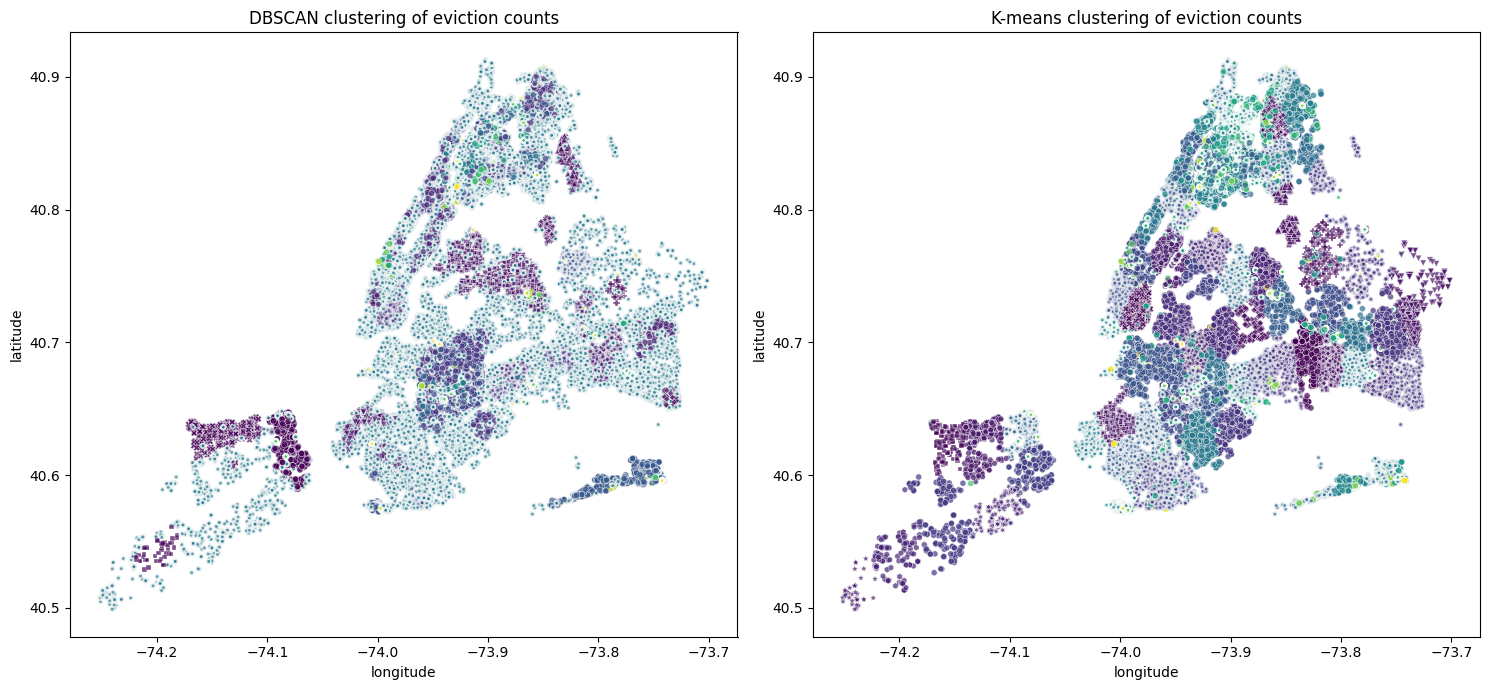

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.scatterplot(x='longitude', y = 'latitude', hue = 'cluster', style  = 'cluster', data = evictions_cleaned,
                s = 20, palette='viridis', alpha = 0.7, ax = ax1, legend = False)

ax1.set_title('DBSCAN clustering of eviction counts')
# ax1.legend(bbox_to_anchor=(1.05, 1), loc= 'upper left')
# valid_clusters = [c for c in evictions_cleaned['cluster'].unique() if c != -1]
# n_clusters = len(valid_clusters)
# palette = sns.color_palette('viridis', n_clusters)
# color_map = {-1: 'red'}
# color_map.update({cluster: palette[i] for i, cluster in enumerate(valid_clusters)})

sns.scatterplot(x='longitude', y = 'latitude', hue = 'cluster_kmeans', style  = 'cluster_kmeans', data = evictions_cleaned,
                s = 20, palette='viridis', alpha = 0.7, ax = ax2, legend = False)

ax2.set_title('K-means clustering of eviction counts')
# ax2.legend(bbox_to_anchor=(1.05, 1), loc= 'upper left')
plt.tight_layout()
plt.show()
# similar colors now, and the colors share the same order of the clusters (but do not really mean the same median of the clusters)
# just shows how different and similar HDBSCAN and k-means can be when making clustering decisions.

## **Step 3.3: If we re-run the simple scatter plot, we will see more clear gradient colors, because we re-ordered the clusters based on their median eviction rates**

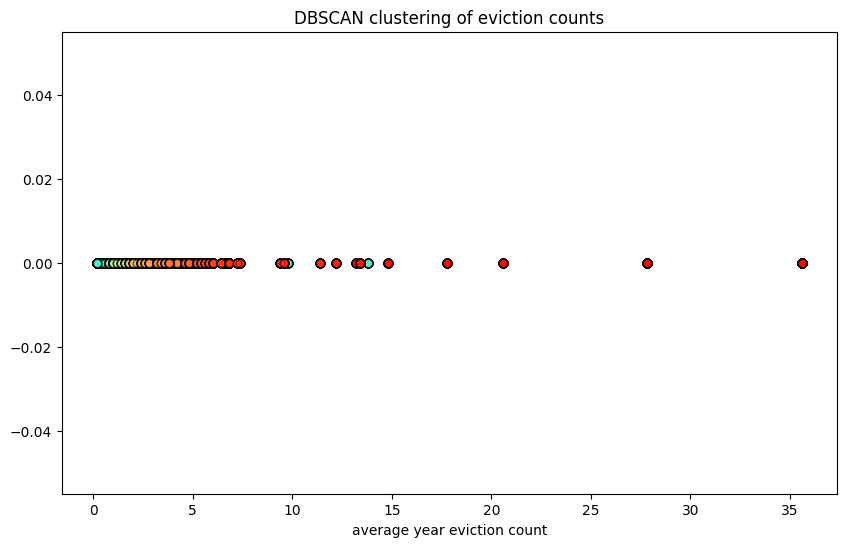

In [189]:
# better visuals
plt.figure(figsize=(10, 6))

for cluster_id in set(evictions_cleaned['cluster']):
    # default: noise points
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        color = plt.cm.rainbow(cluster_id / n_clusters)
        label = f'cluster {cluster_id}'

    plt.scatter(evictions_cleaned[evictions_cleaned['cluster'] == cluster_id]['average_year_eviction_count'],
                [0] * len(evictions_cleaned[evictions_cleaned['cluster'] == cluster_id]),
                color=color, label=label, alpha=0.6, edgecolor='k')

plt.title('DBSCAN clustering of eviction counts')
plt.xlabel('average year eviction count')
# plt.legend()
plt.show()


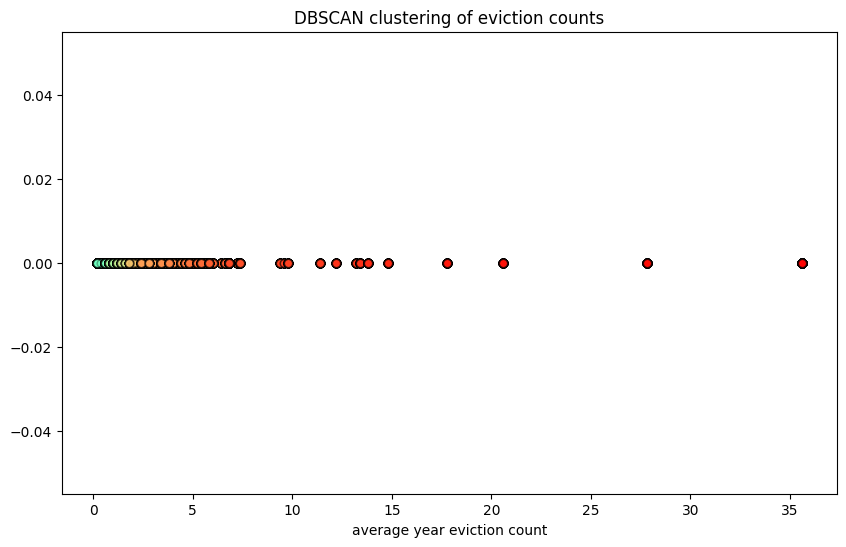

In [190]:
# better visuals
plt.figure(figsize=(10, 6))

for cluster_id in set(evictions_cleaned['cluster_kmeans']):
    # default: noise points
    if cluster_id == -1:
        color = 'black'
        label = 'Noise'
    else:
        color = plt.cm.rainbow(cluster_id / n_clusters)
        label = f'cluster {cluster_id}'

    plt.scatter(evictions_cleaned[evictions_cleaned['cluster_kmeans'] == cluster_id]['average_year_eviction_count'],
                [0] * len(evictions_cleaned[evictions_cleaned['cluster_kmeans'] == cluster_id]),
                color=color, label=label, alpha=0.6, edgecolor='k')

plt.title('DBSCAN clustering of eviction counts')
plt.xlabel('average year eviction count')
# plt.legend()
plt.show()
